In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV



C:\Users\lysla\AppData\Local\Temp\ipykernel_17196\3447166946.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
path = 'Cleaned_Airbnb.csv'

df = pd.read_csv(path)
df.head()

,Unnamed: 0,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,72635,2/4/2011,0,0,1.0,1,0,6,2.5,...,0,0,1,1,0,1,0,0,0,1
1,1,5386323,2/17/2015,0,0,1.0,1,1,2,0.0,...,0,0,1,0,0,0,0,0,0,0
2,2,8826517,10/10/2015,0,0,2.0,1,1,2,1.5,...,0,0,1,1,0,1,1,1,1,1
3,3,8828616,10/10/2015,0,0,2.0,1,1,2,1.5,...,0,0,1,1,0,1,1,1,1,1
4,4,8536913,4/13/2015,98%,0,301.0,1,1,6,2.0,...,0,0,1,1,0,1,0,1,1,1


In [3]:
df['host_since'] = pd.to_datetime(df['host_since'], format='%m/%d/%Y')

# Calculate the number of years from today
today = pd.Timestamp.now()
df['host_year'] = (today - df['host_since']).dt.days / 365.25
df.drop(columns=['host_since'], inplace=True)

df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace({'\$': '', ',': ''}, regex=True).astype(float)

df['bedrooms'] = df['bedrooms'].fillna(0)

missing_values = df.isna().sum()

# Display the columns with missing values
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [4]:
#Standardize Data
dfcolumns = df.columns.values.tolist()

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=dfcolumns)

df_scaled.drop(columns=['Unnamed: 0','id'],inplace=True)
df.drop(columns=['Unnamed: 0','id'],inplace=True)
df_scaled.head()

,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,...,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer,host_year
0,-1.536857,-0.407266,-0.195220,0.047315,-1.438617,0.598434,1.317700,-0.647529,0.481497,0.033879,...,-0.178135,0.269102,0.534700,-0.172934,0.283511,-0.588991,-1.129254,-1.776835,0.516861,1.802101
1,-1.536857,-0.407266,-0.195220,0.047315,0.695112,-0.888232,-1.875593,-0.647529,-0.727699,-0.464160,...,-0.178135,0.269102,-1.870209,-0.172934,-3.527196,-0.588991,-1.129254,-1.776835,-1.934755,-0.983888
2,-1.536857,-0.407266,-0.177089,0.047315,0.695112,-0.888232,0.040383,-0.647529,-0.727699,-0.461683,...,-0.178135,0.269102,0.534700,-0.172934,0.283511,1.697819,0.885540,0.562798,0.516861,-1.428059
3,-1.536857,-0.407266,-0.177089,0.047315,0.695112,-0.888232,0.040383,-0.647529,-0.727699,-0.461683,...,-0.178135,0.269102,0.534700,-0.172934,0.283511,1.697819,0.885540,0.562798,0.516861,-1.428059
4,0.707641,-0.407266,5.244168,0.047315,0.695112,0.598434,0.679041,1.109812,0.481497,0.774743,...,-0.178135,0.269102,0.534700,-0.172934,0.283511,-0.588991,0.885540,0.562798,0.516861,-1.087843


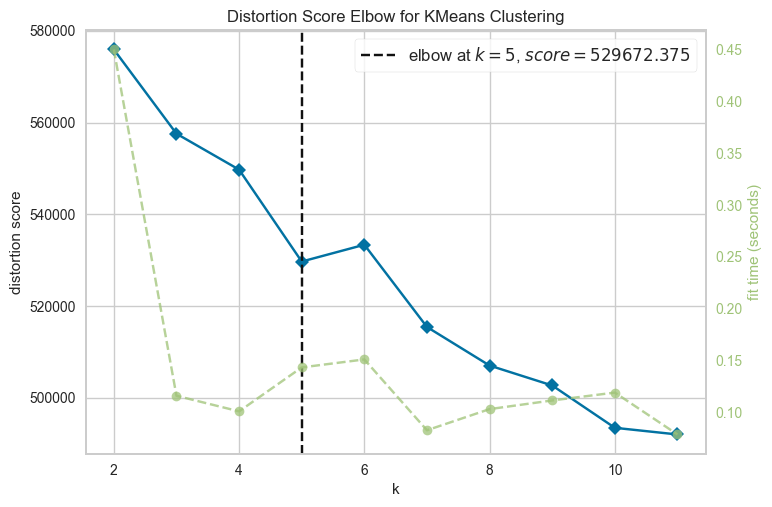

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# set the model type to k-means
model = KMeans()

# generate an elbow plot for k = 2 to 12 clusters using the scaled data
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df_scaled)
visualizer.show()

In [6]:
# Create an instance of KMeans with the desired value of k and fit to the scaled data
kmeans = KMeans(n_clusters=7, random_state=904)
kmclus=kmeans.fit(df_scaled)

clusters = kmeans.fit_predict(df_scaled)

#append cluster to original data
df['cluster']=clusters

df.info()

# Evaluate cluster sizes to insure that they are similar
print(df['cluster'].value_counts())

# Examine the means of each variable by cluster
df_desc = df.groupby('cluster').mean()
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
     print(df_desc)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Columns: 109 entries, host_response_rate to cluster
dtypes: bool(35), float64(17), int32(1), int64(56)
memory usage: 3.5 MB
cluster
6    1368
5    1222
2    1178
0     998
4     757
1     173
3     124
Name: count, dtype: int64
         host_response_rate  host_is_superhost  host_listings_count  \
cluster                                                               
0                     0.877              0.282                2.572   
1                     0.799              0.231                7.578   
2                     0.293              0.025                1.973   
3                     0.623              0.089                2.718   
4                     0.417              0.041               13.316   
5                     0.841              0.184               37.097   
6                     0.822              0.154                4.776   

         host_has_profile_pic  host_identity_verified  acc

Profile Clusters

Availability_30_days


<Figure size 800x400 with 0 Axes>

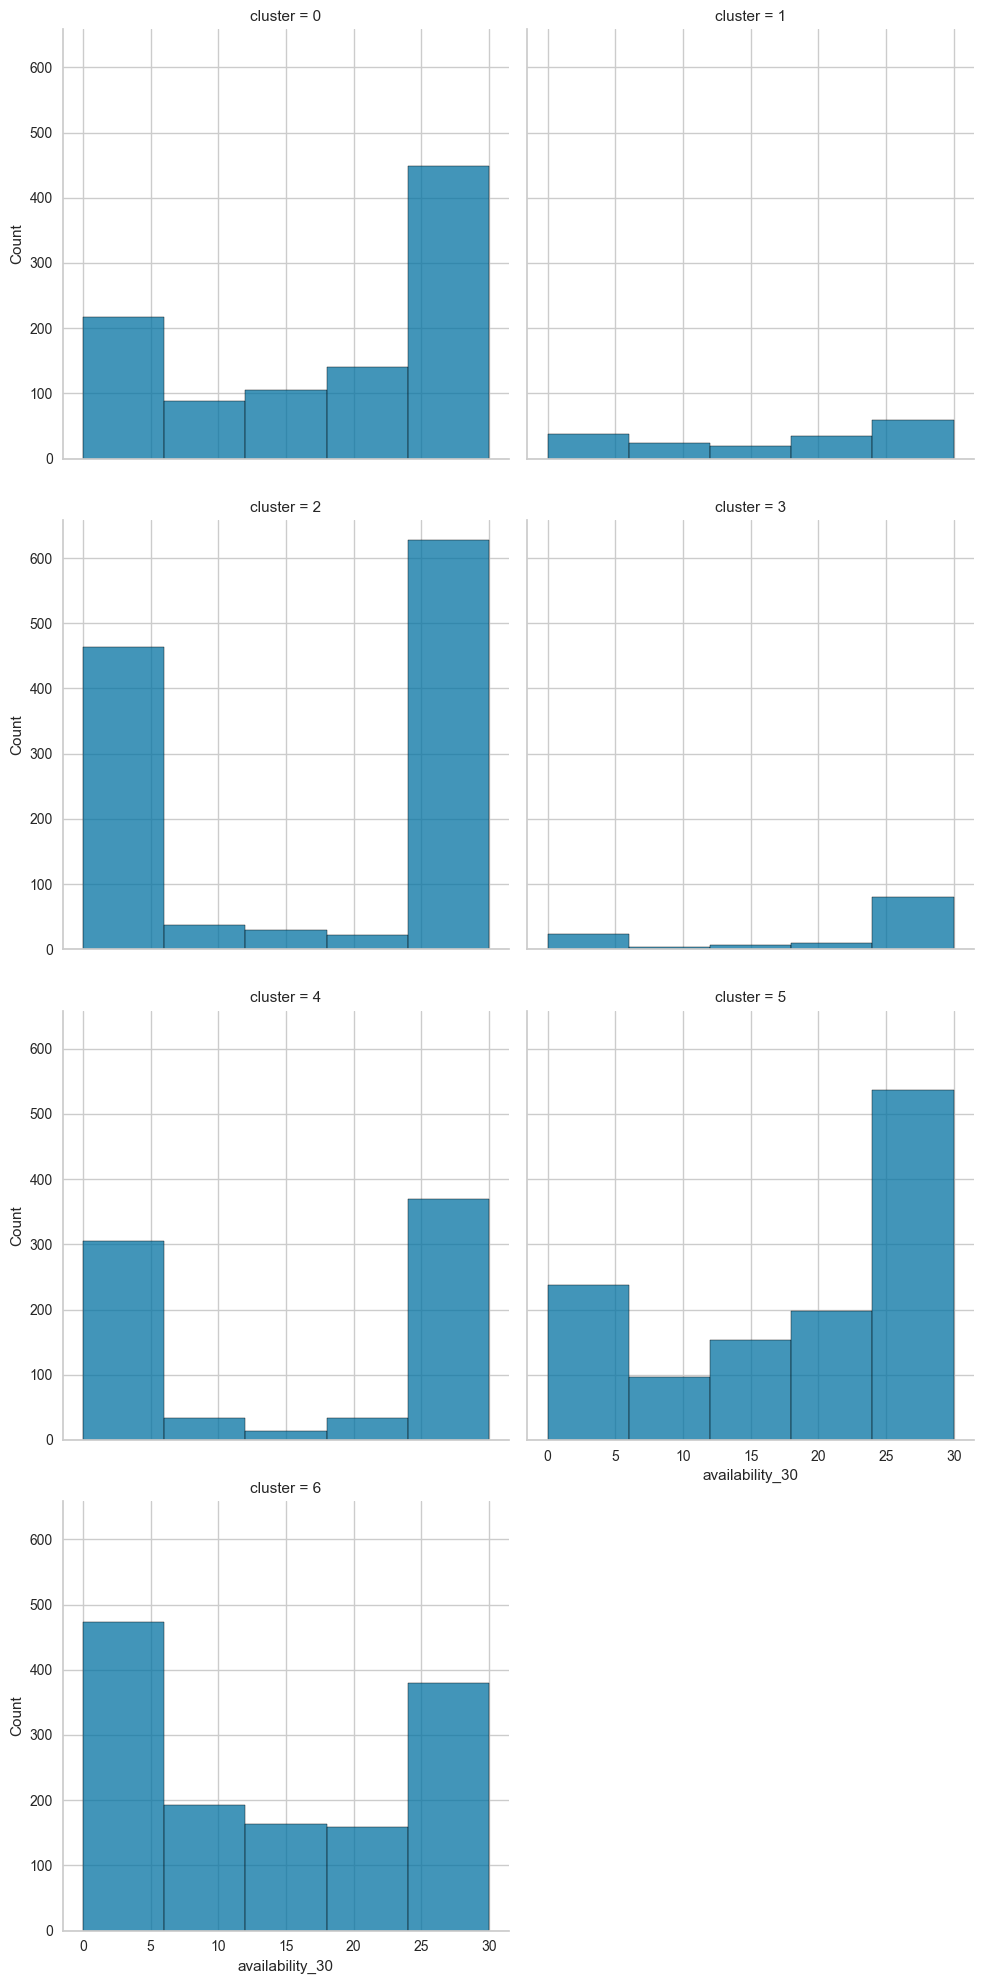

        availability_30                                                    
                  count       mean        std  min    25%   50%   75%   max
cluster                                                                    
0                 998.0  18.073146  11.239691  0.0   7.00  21.0  29.0  30.0
1                 173.0  16.612717  10.732761  0.0   6.00  19.0  27.0  30.0
2                1178.0  16.782683  14.088396  0.0   0.00  28.0  30.0  30.0
3                 124.0  21.516129  11.505025  0.0  15.75  28.0  30.0  30.0
4                 757.0  16.027741  13.870071  0.0   0.00  22.0  30.0  30.0
5                1222.0  18.415712  10.840471  0.0  10.00  21.0  29.0  30.0
6                1368.0  13.336257  11.313428  0.0   0.00  12.0  25.0  30.0


In [9]:
#Availability 90 days
plt.figure(figsize=(8,4))
print("Availability_30_days")
sns.displot(data=df, x="availability_30", bins=5, col='cluster', col_wrap=2, common_bins=True)
plt.show()

dfrom = df[['availability_30', 'cluster']]

df_desc1 = dfrom.groupby('cluster').describe()
print(df_desc1)

Availability_60_days


<Figure size 800x400 with 0 Axes>

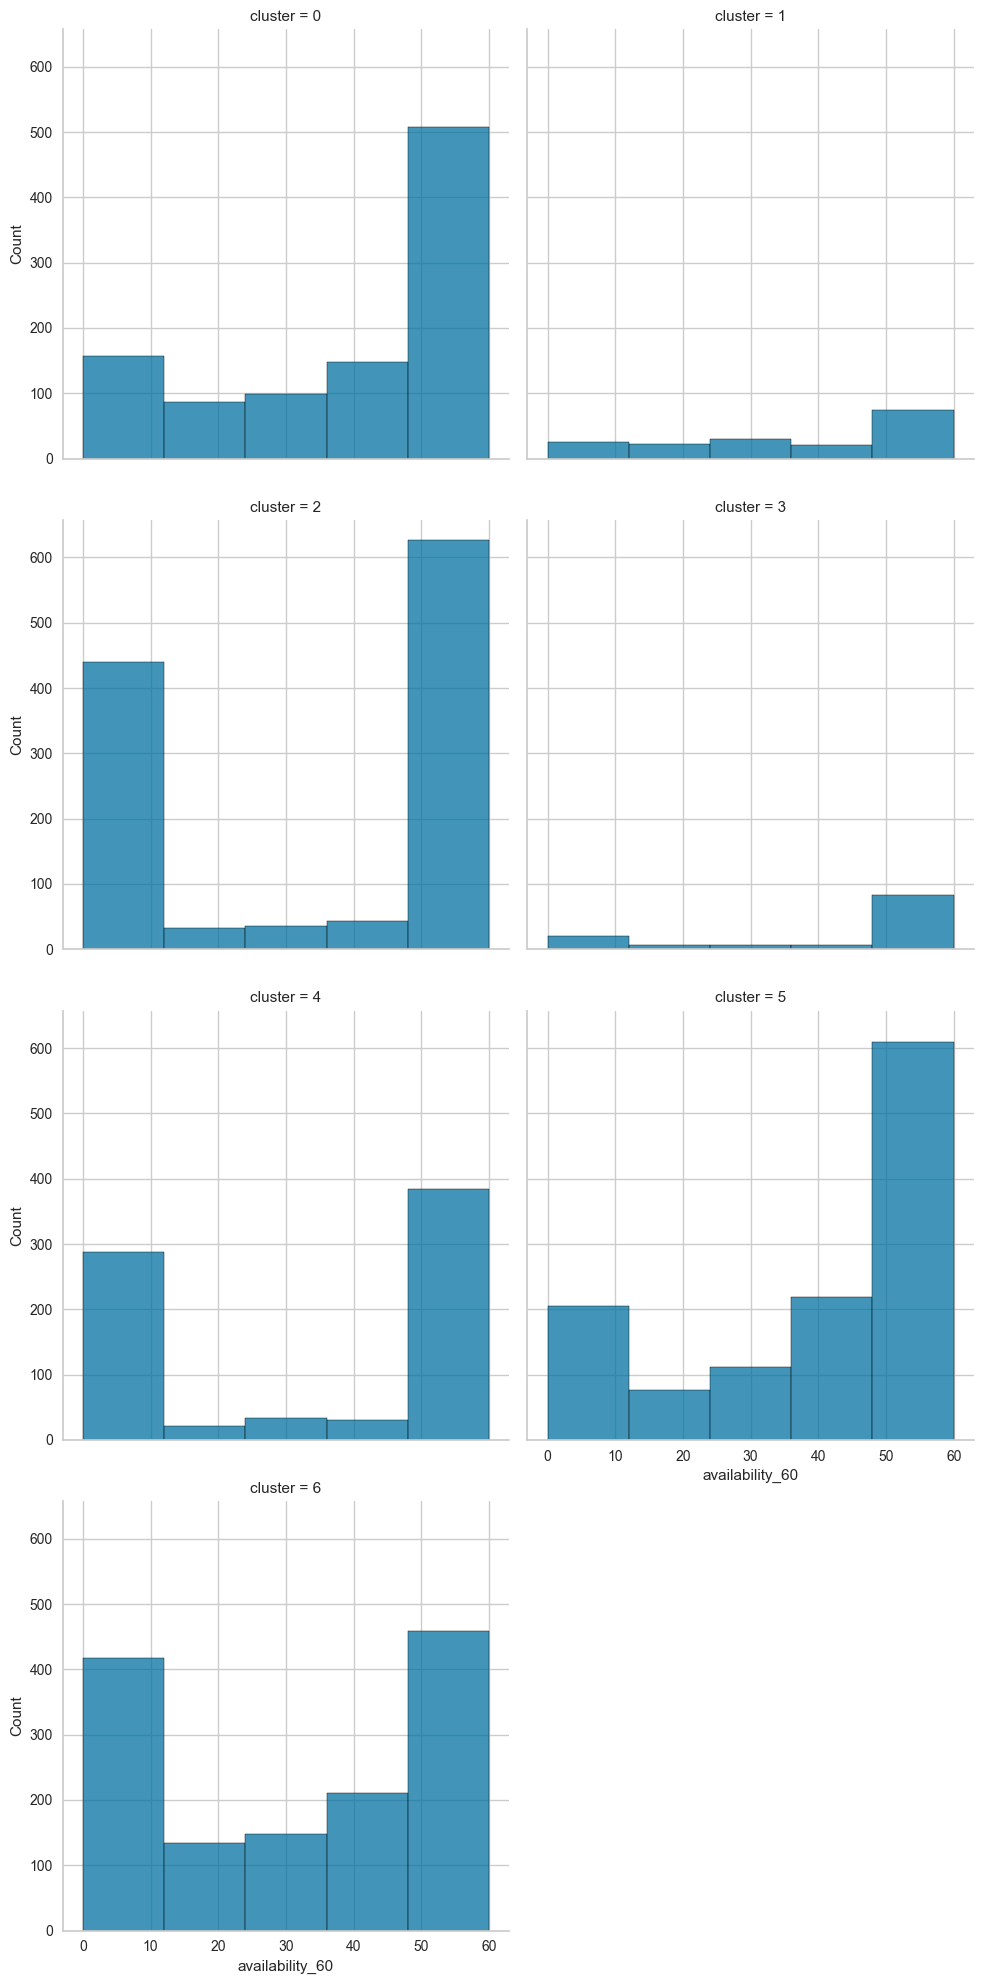

        availability_60                                                    
                  count       mean        std  min    25%   50%   75%   max
cluster                                                                    
0                 998.0  40.024048  20.863684  0.0  25.00  49.0  58.0  60.0
1                 173.0  36.820809  19.942861  0.0  22.00  42.0  56.0  60.0
2                1178.0  34.692699  27.828470  0.0   0.00  57.0  60.0  60.0
3                 124.0  44.161290  22.320790  0.0  28.75  58.0  60.0  60.0
4                 757.0  33.651255  27.071772  0.0   0.00  48.0  60.0  60.0
5                1222.0  39.965630  20.869482  0.0  27.00  47.0  58.0  60.0
6                1368.0  30.765351  22.740186  0.0   5.00  34.0  53.0  60.0


In [10]:
#Availability 60 days
plt.figure(figsize=(8,4))
print("Availability_60_days")
sns.displot(data=df, x="availability_60", bins=5, col='cluster', col_wrap=2, common_bins=True)
plt.show()

dfrom = df[['availability_60', 'cluster']]

df_desc1 = dfrom.groupby('cluster').describe()
print(df_desc1)

Availability_90_days


<Figure size 800x400 with 0 Axes>

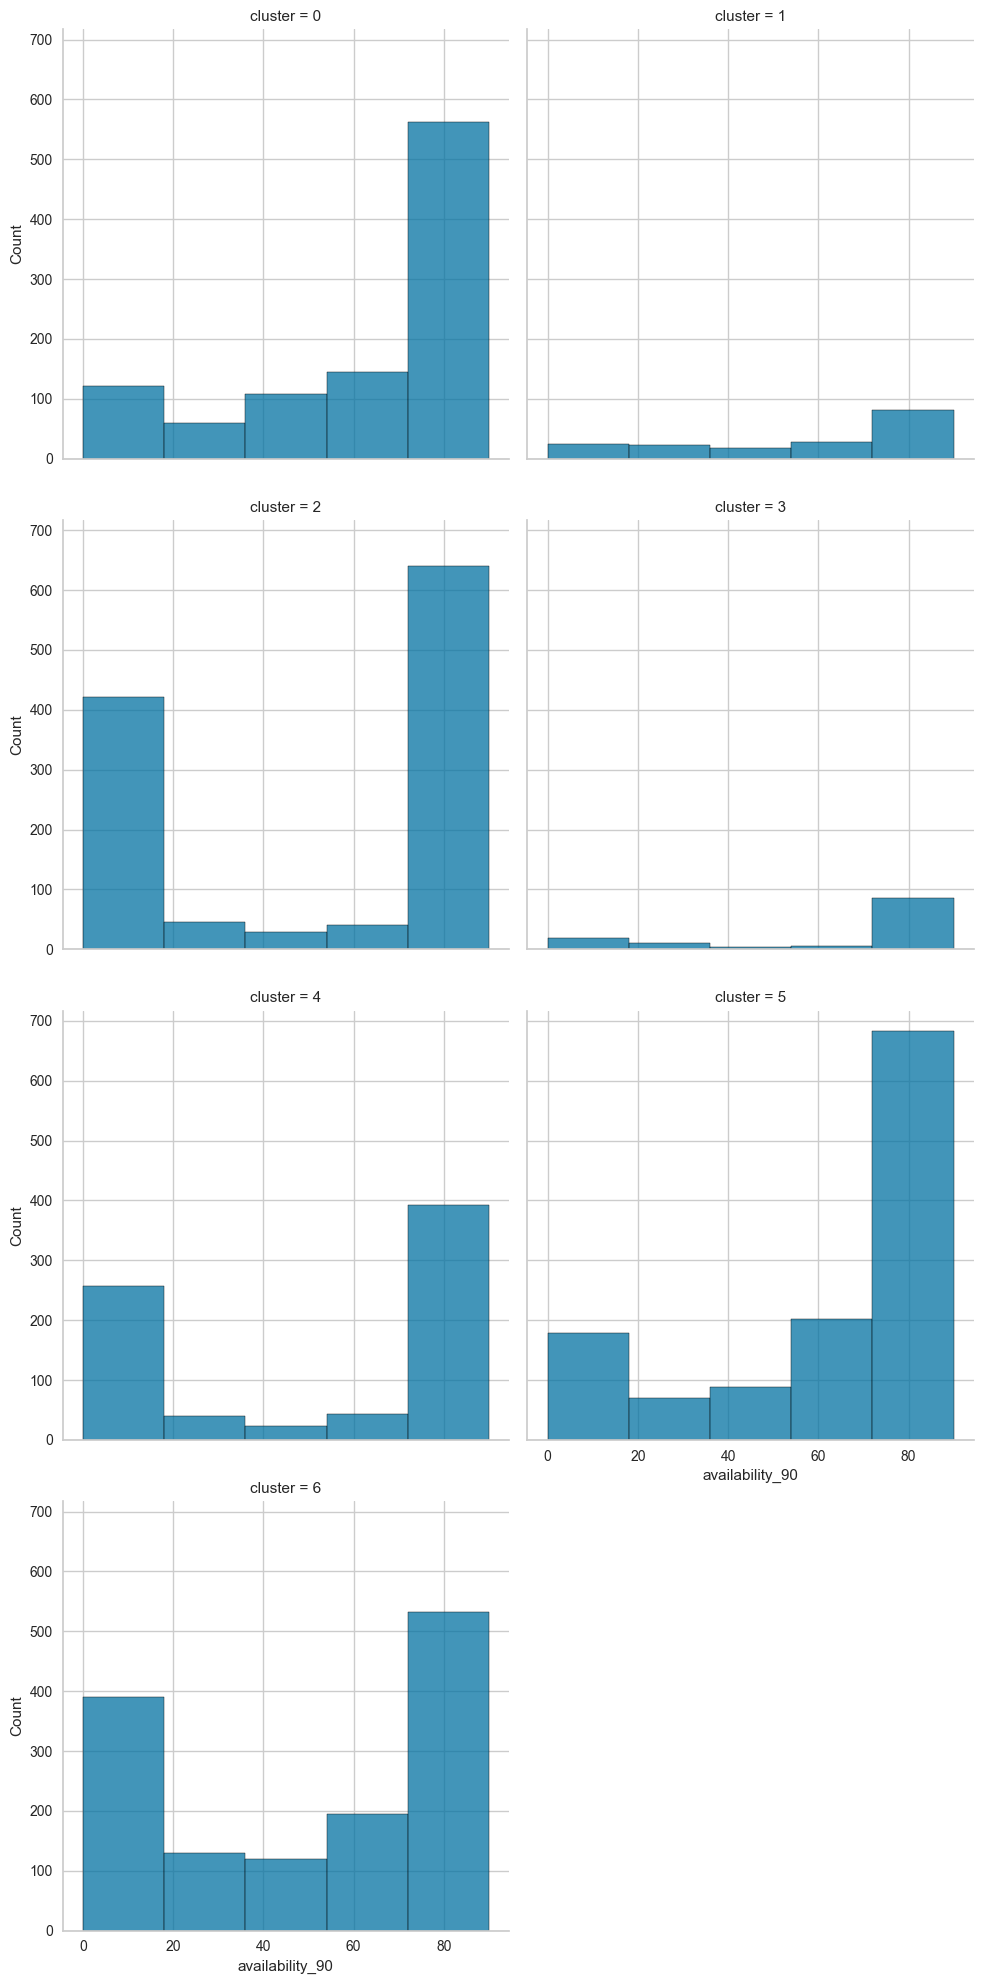

        availability_90                                                    
                  count       mean        std  min    25%   50%   75%   max
cluster                                                                    
0                 998.0  64.283567  29.282643  0.0  48.25  77.0  88.0  90.0
1                 173.0  58.514451  29.862204  0.0  33.00  67.0  86.0  90.0
2                1178.0  53.075552  41.555178  0.0   0.00  87.0  90.0  90.0
3                 124.0  67.879032  32.524311  0.0  53.00  88.0  90.0  90.0
4                 757.0  52.684280  39.995065  0.0   0.00  77.0  90.0  90.0
5                1222.0  63.520458  30.263043  0.0  48.00  76.0  88.0  90.0
6                1368.0  49.370614  34.430481  0.0  11.00  59.0  82.0  90.0


In [8]:
#Availability 90 days
plt.figure(figsize=(8,4))
print("Availability_90_days")
sns.displot(data=df, x="availability_90", bins=5, col='cluster', col_wrap=2, common_bins=True)
plt.show()

dfrom = df[['availability_90', 'cluster']]

df_desc1 = dfrom.groupby('cluster').describe()
print(df_desc1)